In [27]:
import json

from process_bigraph import Composite, pp
import numpy as np

from bsp import app_registrar
from bsp.utils.membrane_utils import get_vertices, get_times
from bsp.processes.simple_membrane_process import SimpleMembraneProcess


test_state_init_fp = '../test-membrane-initial.json'
oblate = "../fixtures/sample_meshes/oblate.ply"
prolate = "../fixtures/sample_meshes/prolate.ply"

repressilator_fp  = '../fixtures/sbml-core/Elowitz-Nature-2000-Repressilator/BIOMD0000000012_url.xml'
min_fp = '../fixtures/smoldyn/MinE.txt'

In [16]:
from smoldyn import Simulation

from smoldyn import _smoldyn as sm

simulation = Simulation.fromFile(min_fp)

dir(simulation)

--------------------------------------------------------------
Running Smoldyn 2.73

CONFIGURATION FILE
 Path: '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/tests/fixtures/smoldyn/'
 Name: 'MinE.txt'
 Reading file: '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/tests/fixtures/smoldyn/MinE.txt'
 Loaded file successfully
 setting up molecules
 setting up virtual boxes
 setting up compartments
 setting up reactions
 setting up surfaces
 setting up graphics

SIMULATION PARAMETERS
 file: /Users/alexanderpatrie/Desktop/repos/biosimulator-processes/tests/fixtures/smoldyn/MinE.txt
 starting clock time: Mon Feb 10 20:53:34 2025
 3 dimensions
 Accuracy level: 5
 Random number seed: 1
 Time from 0 to 10 step 0.002

GRAPHICS PARAMETERS
 No graphical output

WALL PARAMETERS
 wall 0: dimension x, at -2
 wall 1: dimension x, at 2
 wall 2: dimension y, at -0.5
 wall 3: dimension y, at 0.5
 wall 4: dimension z, at -0.5
 wall 5: dimension z, at 0.5
 system volume: 4
 system 

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__todisp_text__',
 'accuracy',
 'addBidirectionalReaction',
 'addBox',
 'addCommand',
 'addCommandStr',
 'addCompartment',
 'addCompartmentLogic',
 'addCompartmentMolecules',
 'addCompartmentPoint',
 'addCompartmentSurface',
 'addCylinder',
 'addDisk',
 'addGraphics',
 'addHemisphere',
 'addLattice',
 'addLatticeMolecules',
 'addLatticePort',
 'addLatticeReaction',
 'addLatticeSpecies',
 'addMolList',
 'addMoleculePerBox',
 'addMolecules',
 'addOutputData',
 'addOutputFile',
 'addPanel',
 'addPanelNeighbor',
 'addPartition',
 'addPath2D',
 'addPort',
 'addPortMolecule',
 'addReaction',
 'addRectangle',
 'addSolutionMolecules',
 'addSpec

corners: (-2,-0.5,-0.5) and (2,0.5,0.5)

MOLECULE PARAMETERS
 6 molecule lists:
  list1, list2, list3, list4, list5, unassignedlist
 4 species defined:
 MinD_ATP:
  solution: difc=2.5, rms step=0.1, list=list1, number=0
  front: difc=0.01, rms step=0.00632456, list=list2, number=4000
  solution: color= 0,0,0.6, display size= 2
  front: color= 0,0.6,0, display size= 4
 MinD_ADP:
  solution: difc=2.5, rms step=0.1, list=list3, number=0
  solution: color= 0.4,0.6,1, display size= 2
 MinE:
  solution: difc=2.5, rms step=0.1, list=list4, number=1400
  solution: color= 1,0,0, display size= 2
 MinDMinE:
  front: difc=0.01, rms step=0.00632456, list=list5, number=0
  front: color= 0.2,1,0.2, display size= 4
 Overall spatial resolution: 0.1

SURFACE PARAMETERS
 Molecule lists checked after diffusion: list1 list2 list3 list4 list5
 Molecule lists checked after reactions: list2 list5
 Molecule lists checked for surface-bound molecules: list2 list3 list4 list5 unassignedlist
 Surfaces defined: 1



In [18]:
import smoldyn . _smoldyn as smol

dir(smol)

['CallbackFunc',
 'DrawMode',
 'ErrorCode',
 'Graphics',
 'MolecState',
 'PanelFace',
 'PanelShape',
 'RevParam',
 'SMLflag',
 'Simulation',
 'SpeciesRepresentation',
 'SrfAction',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__version__',
 'color2RGBA',
 'errorCodeToString',
 'getError',
 'getVersion',
 'loadModel',
 'prepareSimFromFile',
 'setDebugMode',
 'simstruct',
 'wallstruct']

In [25]:
simulation = smol.Simulation(min_fp, '')

In [26]:
dir(simulation)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'accuracy',
 'addCommand',
 'addCompartment',
 'addCompartmentLogic',
 'addCompartmentMolecules',
 'addCompartmentPoint',
 'addCompartmentSurface',
 'addLattice',
 'addLatticeMolecules',
 'addLatticePort',
 'addLatticeReaction',
 'addLatticeSpecies',
 'addMolList',
 'addOutputData',
 'addOutputFile',
 'addPanel',
 'addPanelNeighbor',
 'addPort',
 'addPortMolecule',
 'addReaction',
 'addSolutionMolecules',
 'addSpecies',
 'addSurface',
 'addSurfaceMolecules',
 'addSurfaceUnboundedEmitter',
 'addTextDisplay',
 'connect',
 'count',
 'displaySim',
 'dt',
 'getBoundaries',
 'getCompartmentIndex',
 'getCompartmentIndexNT',
 'getCompartmentName',
 'getLatti

In [15]:
simulation.addSpecies("MinD_ATP")

Libsmoldyn warning in smolAddSpecies: this species has already been declared


AssertionError: Failed to add molecule ErrorCode.warning

In [3]:
x = np.random.random((10, 3))

x

array([[0.03896398, 0.70099618, 0.6635852 ],
       [0.80350153, 0.69924569, 0.46865984],
       [0.79819041, 0.60160126, 0.9299135 ],
       [0.98337045, 0.92423239, 0.02912845],
       [0.05237993, 0.31345834, 0.01079635],
       [0.21482034, 0.89683977, 0.06165543],
       [0.2068204 , 0.81608541, 0.52186864],
       [0.22339256, 0.18265508, 0.25779613],
       [0.61749326, 0.41194031, 0.59061826],
       [0.90214186, 0.78064107, 0.14038654]])

In [4]:
import numpy as np

def get_axis_vertices(vertices, axis: int, func):
    return func([vertex[axis] for vertex in vertices])


def get_bounds(vertices, axis: int) -> tuple[float, float]:
    ax_min = get_axis_vertices(vertices, axis, min)
    ax_max = get_axis_vertices(vertices, axis, max)
    return ax_min, ax_max


def get_kth_boundaries(vertices):
    x_min, x_max = get_bounds(vertices, 0)
    y_min, y_max = get_bounds(vertices, 1)
    z_min, z_max = get_bounds(vertices, 2)

    return (
        [x_min, y_min, z_min],
        [x_max, y_max, z_max],
    )


get_kth_boundaries(x)

([0.03896397668863061, 0.18265507629710387, 0.010796350346929051],
 [0.9833704521637556, 0.9242323946110161, 0.9299134988398198])

In [5]:
species_count = simulation.count()['species']
species_names = []
for index in range(species_count):
    species_name = simulation.getSpeciesName(index)

    if 'empty' not in species_name.lower():
        species_names.append(species_name)

In [6]:
species_names

['MinD_ATP', 'MinD_ADP', 'MinE', 'MinDMinE']

In [7]:
from random import random
import math


def compute_vm(t, args):
    x, y = args
    return math.sin(t) + x * y * random()

simulation.connect(func=compute_vm, target='MinD_ATP.difc', step=10, args=[1, 2.1])
# ca = simulation.addSpecies('ca', difc=1, color='blue', display_size=1)

True

In [9]:
simulation.run(100, 1)

Libsmoldyn notification from smolRunSim: Simulation complete


9.979291186434061

In [29]:
import json
input_composite_state = {
    'particle': {
        '_type': 'process',
        'address': 'local:smoldyn-process',
        'config': {
            'model': {
                'model_source': min_fp,
            }
        },
        'inputs': {
            'species_counts': ['species_counts_store'],
            'particles': ['particles_store'],
            'geometry': ['geometry_store'],
            'net_forces': ['net_forces_store'],
            'notable_vertices': ['notable_vertices_store'],
        },
        'outputs': {
            'species_counts': ['species_counts_store'],
            'particles': ['particles_store'],
        }
    },
    'membrane': {
        '_type': 'process',
        'address': 'local:simple-membrane-process',
        'config': {
            'characteristic_time_step': 1,
            'geometry': {
                'type': 'icosphere',
                'parameters': {
                    'radius': 1.0,
                    'subdivision': 2
                }
            },
            'tension_model': {
                'modulus': 0.1,
                'preferred_area': 12.4866
            },
            'osmotic_model': {
                'preferred_volume': 0.7 * 3.14 * 4 / 3,
                'reservoir_volume': 1,
                'strength': 0.02,
                'volume': 2.9
            },
            'parameters': {
                'bending': {
                    'Kbc': 8.22e-05
                },
                'damping': 0.05
            },
            'tolerance': 1e-11,
            'console_output': False
        },
        'inputs': {
            'geometry': ['geometry_store'],
            'velocities': ['velocities_store'],
            'protein_density': ['protein_density_store'],
            'volume': ['volume_store'],
            'preferred_volume': ['preferred_volume_store'],
            'reservoir_volume': ['reservoir_volume_store'],
            'surface_area': ['surface_area_store'],
            'osmotic_strength': ['osmotic_strength_store'],
        },
        'outputs': {
            'geometry': ['geometry_store'],
            'velocities': ['velocities_store'],
            'protein_density': ['protein_density_store'],
            'volume': ['volume_store'],
            'preferred_volume': ['preferred_volume_store'],
            'reservoir_volume': ['reservoir_volume_store'],
            'surface_area': ['surface_area_store'],
            'net_forces': ['net_forces_store'],
            'notable_vertices': ['notable_vertices_store']
        }
    },
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'geometry': 'GeometryType',
                'velocities': 'VelocitiesType',
                'protein_density': 'ProteinDensityType',
                'volume': 'float',
                'preferred_volume': 'float',
                'reservoir_volume': 'float',
                'surface_area': 'float',
                'net_forces': 'MechanicalForcesType',
                'notable_vertices': 'list[boolean]',
            }
        },
        'inputs': {
            'geometry': ['geometry_store'],
            'velocities': ['velocities_store'],
            'protein_density': ['protein_density_store'],
            'volume': ['volume_store'],
            'preferred_volume': ['preferred_volume_store'],
            'reservoir_volume': ['reservoir_volume_store'],
            'surface_area': ['surface_area_store'],
            'net_forces': ['net_forces_store'],
            'notable_vertices': ['notable_vertices_store'],
        }
    }
}

with open('/Users/alexanderpatrie/Downloads/example_hybrid.json', 'w') as outfile:
    json.dump(input_composite_state, outfile, indent=4)

In [4]:
sim = Composite(config={'state': input_composite_state}, core=app_registrar.core)

In [5]:
# sim.state['membrane']['instance'].initial_state()

In [6]:
total_time = 10
sim.run(total_time)

Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0
Duration at interval 1.0: 1.0


In [7]:
sim_results = sim.gather_results()[('emitter',)]

In [9]:
from process_bigraph import pp

pp(sim_results[0])

{ 'geometry': { 'faces': [ [0, 42, 44],
                           [12, 43, 42],
                           [14, 44, 43],
                           [42, 43, 44],
                           [11, 45, 47],
                           [13, 46, 45],
                           [12, 47, 46],
                           [45, 46, 47],
                           [5, 48, 50],
                           [14, 49, 48],
                           [13, 50, 49],
                           [48, 49, 50],
                           [12, 46, 43],
                           [13, 49, 46],
                           [14, 43, 49],
                           [46, 49, 43],
                           [0, 44, 52],
                           [14, 51, 44],
                           [16, 52, 51],
                           [44, 51, 52],
                           [5, 53, 48],
                           [15, 54, 53],
                           [14, 48, 54],
                           [53, 54, 48],
                    

In [10]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Initialize scatter plot (we'll update this later)
sc = ax.scatter([], [], [], c='blue', marker='o')

# Set axis limits (adjust based on your data)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Membrane Vertex Animation")

def get_times(sim):
    return [t for t in range(
        len(sim.gather_results()[('emitter',)])
    )]

def update(frame):
    # Get the vertex positions for the current timestep
    vertices = sim_results[frame]['geometry']['vertices']

    # Extract x, y, z coordinates
    x, y, z = vertices[::3], vertices[1::3], vertices[2::3]

    # Update scatter plot data
    sc._offsets3d = (x, y, z)

    return sc,


fig.colorbar(sc, ax=ax, label='Intensity')
ani = animation.FuncAnimation(fig, update, len(get_times(sim)), blit=False)
HTML(ani.to_jshtml())

ValueError: shapes (4,4) and (4,54,3) not aligned: 4 (dim 1) != 54 (dim 1)

ValueError: shapes (4,4) and (4,54,3) not aligned: 4 (dim 1) != 54 (dim 1)

<Figure size 800x600 with 2 Axes>

In [18]:
frame = 3
vertices = sim_results[frame]['geometry']['vertices'][:162]

In [25]:
x = np.array([vertex[0] for vertex in vertices])
y = np.array([vertex[1] for vertex in vertices])
z = np.array([vertex[2] for vertex in vertices])

{ 'geometry': { 'faces': [ [0, 42, 44],
                           [12, 43, 42],
                           [14, 44, 43],
                           [42, 43, 44],
                           [11, 45, 47],
                           [13, 46, 45],
                           [12, 47, 46],
                           [45, 46, 47],
                           [5, 48, 50],
                           [14, 49, 48],
                           [13, 50, 49],
                           [48, 49, 50],
                           [12, 46, 43],
                           [13, 49, 46],
                           [14, 43, 49],
                           [46, 49, 43],
                           [0, 44, 52],
                           [14, 51, 44],
                           [16, 52, 51],
                           [44, 51, 52],
                           [5, 53, 48],
                           [15, 54, 53],
                           [14, 48, 54],
                           [53, 54, 48],
                    

/var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/ipykernel_95742/2851472525.py:45: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(sc, ax=ax, label='Intensity')


TypeError: list indices must be integers or slices, not tuple

Error in callback <function _draw_all_if_interactive at 0x166cc75b0> (for post_execute), with arguments args (),kwargs {}:


TypeError: list indices must be integers or slices, not tuple

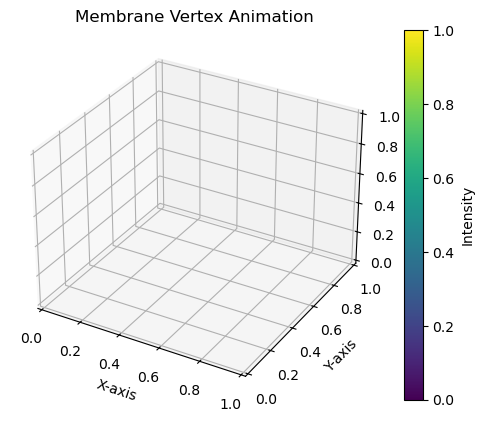

In [33]:
pp(sim_results[0])
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Membrane Vertex Animation")


def get_num_timepoints(sim):
    return len([t for t in range(
        len(sim.gather_results()[('emitter',)])
    )])


def update(frame):
    # Get the vertex positions for the current timestep
    vertices = sim_results[frame]['geometry']['vertices'][:162]

    dataset = vertices
    mask = np.copy(dataset[frame, :, :, :])
    z, y, x = np.where(mask == 1)
    volume = dataset[frame]['geometry']['vertices'][:, :, :]
    print(z)

    # Extract x, y, z coordinates
    x = np.array([vertex[0] for vertex in vertices])
    y = np.array([vertex[1] for vertex in vertices])
    z = np.array([vertex[2] for vertex in vertices])

    # Update scatter plot data
    scatter = ax.scatter(x, y, z, c=vertices[x, y, z], cmap='viridis')
    ax.set_title(f"Time Index: {frame}")

    return scatter,


fig.colorbar(sc, ax=ax, label='Intensity')
ani = animation.FuncAnimation(fig, update, get_num_timepoints(sim), blit=False)
HTML(ani.to_jshtml())